###  Importing the required libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [3]:
np.random.seed(seed=11)

In [4]:
import os 
print(os.listdir("../input"))

['Answers.csv', 'Questions.csv', 'Tags.csv']


In [5]:
# Importing the database 

df = pd.read_csv("../input/Questions.csv", encoding="ISO-8859-1")

In [6]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [7]:
df=df.head(100000)

In [8]:
tags = pd.read_csv("../input/Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [9]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [10]:
tags=tags.head(100000)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
Id              100000 non-null int64
OwnerUserId     95342 non-null float64
CreationDate    100000 non-null object
ClosedDate      3331 non-null object
Score           100000 non-null int64
Title           100000 non-null object
Body            100000 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 5.3+ MB


In [12]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
Id     100000 non-null int64
Tag    99958 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


## In order to merge both the dataframes, I'll have to group tags by the id of the post since a post can have multiple tags. Use the groupeby function and then merge the dataframes on the id. 

In [13]:
tags['Tag'] = tags['Tag'].astype(str)

In [14]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [15]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [16]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
5,330,c++ oop class nested-class
6,470,.net web-services
7,580,sql-server sql-server-2005 deployment release-...
8,650,c# visual-studio versioning
9,810,windows visual-studio registry installation


In [17]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [18]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [19]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [20]:
df = df.merge(grouped_tags_final, on='Id')

In [21]:
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


## Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [22]:
new_df = df[df['Score']>5]

## Cleaning Data

In [25]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


## There are no missing valeus or dupplicate values. 

In [ ]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

## We only need 3 columns: Body, Title and Tags. 

In [26]:
new_df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [27]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [28]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [29]:
len(all_tags)

27043

In [30]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

4256

In [31]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [32]:
tags_features

['c#',
 'java',
 '.net',
 'c++',
 'python',
 'javascript',
 'php',
 'asp.net',
 'jquery',
 'c',
 'sql',
 'iphone',
 'sql-server',
 'html',
 'ruby',
 'asp.net-mvc',
 'windows',
 'wpf',
 'objective-c',
 'ruby-on-rails',
 'mysql',
 'css',
 'linux',
 'visual-studio',
 'database',
 'performance',
 'django',
 'algorithm',
 'string',
 'unit-testing',
 'xml',
 'svn',
 'eclipse',
 'winforms',
 'multithreading',
 'regex',
 'cocoa-touch',
 'linq',
 'version-control',
 'language-agnostic',
 'perl',
 'security',
 'git',
 'cocoa',
 'arrays',
 'debugging',
 'oop',
 'ajax',
 'oracle',
 'delphi',
 'user-interface',
 'tsql',
 'visual-studio-2008',
 'osx',
 'vb.net',
 'sql-server-2005',
 'android',
 'http',
 'bash',
 'exception',
 'winapi',
 'testing',
 'image',
 'web-services',
 'file',
 'math',
 'wcf',
 'reflection',
 'emacs',
 'vim',
 'shell',
 'generics',
 'unix',
 'design-patterns',
 'design',
 'coding-style',
 'gcc',
 'syntax',
 'json',
 'command-line',
 'optimization',
 'internet-explorer',
 'silv

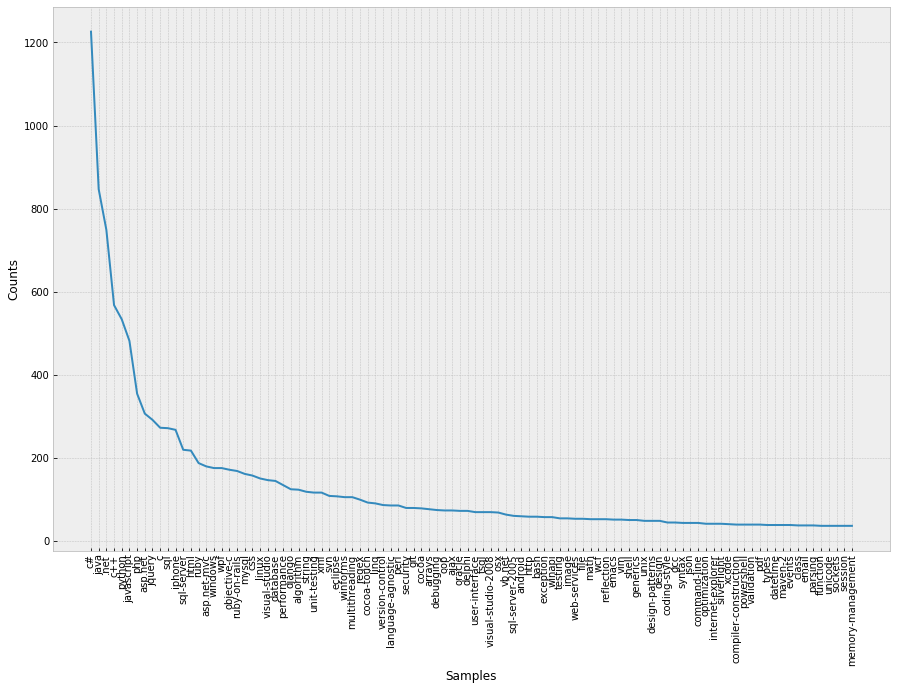

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [34]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [35]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [36]:
new_df.shape

(9123, 5)

In [37]:
new_df.dropna(subset=['Tags'], inplace=True)

In [38]:
new_df.shape

(7965, 5)

# Body

In the next two columns: Body and Title, we will do some text processing as follows:
* Removing html format 
* Lowering text
* Transforming abbreviations 
* Removing punctuation (but keeping words like c# since it's the most popular tag)
* Lemmatizing words
* Removing stop words

In [39]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [40]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [41]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [42]:
token=ToktokTokenizer()

In [43]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [44]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [45]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [46]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))




In [47]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [48]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [49]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [50]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [51]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

## Title

In [52]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

## Let us try to find any patterns in words and the main topics.  

In [53]:
no_topics = 20

In [54]:
text = new_df['Body']

In [55]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [56]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [57]:
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [58]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
val render stuff use view count build collection somewhere row
--------------------------------------------
--------------------------------------------
Topic 1:
event child events bean fire node queue spring handler wpf
--------------------------------------------
--------------------------------------------
Topic 2:
team type interface use available byte mind control fix jquery
--------------------------------------------
--------------------------------------------
Topic 3:
visual studio android convert c# c++ tool java use library
--------------------------------------------
--------------------------------------------
Topic 4:
hash varchar application function want download sql .net server framework
--------------------------------------------
--------------------------------------------
Topic 5:
use file would like get code work way application want
--------------------------------------------
---------------------------------

## Now our data is almost ready to be put into a classifier. I just need to:
* Binarize the tags
* Use a TFIDF for body and Title
The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [59]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

In [60]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [61]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [62]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [63]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

Now it's finally ready. 

2.2 One vs Rest

To evaluate our models, I'll use the jacard score since it's the best fitted for multi label classification. 

In [65]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [66]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 2.794368218097031
Hamming loss: 3.1613308223477716
---
Clf:  SGDClassifier
Jacard score: 48.90772128060264
Hamming loss: 1.046453232893911
---
Clf:  LogisticRegression
Jacard score: 35.05335844318895
Hamming loss: 1.174513496547395
---
Clf:  MultinomialNB
Jacard score: 25.41431261770245
Hamming loss: 1.3515379786566228
---
Clf:  LinearSVC
Jacard score: 48.382506800585894
Hamming loss: 1.0784682988072818
---
Clf:  Perceptron
Jacard score: 44.22052332127662
Hamming loss: 1.5134965473948525
---
Clf:  PassiveAggressiveClassifier
Jacard score: 48.90787074402893
Hamming loss: 1.2492153170119271
---


## MLP Classifier

In [67]:
mlpc = MLPClassifier()
mlpc.fit(X_train, y_train)

y_pred = mlpc.predict(X_test)

print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 45.794099183929696
Hamming loss: 1.2222222222222223
---


**2.4 Random Forest**

In [68]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 36.827788240217615
Hamming loss: 1.1996233521657251
---


## GridSearch CV on the best classifier 

In [69]:
param_grid = {'estimator__C':[1,10,100,1000]}

In [70]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... estimator__C=1, score=46.64705882352941, total=   1.1s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .......... estimator__C=1, score=47.96339869281046, total=   1.1s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] .......... estimator__C=1, score=48.46153846153846, total=   1.1s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[CV] .......... estimator__C=1, score=48.61198325484039, total=   1.1s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s


[CV] ........... estimator__C=1, score=47.1415489272632, total=   1.1s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.6s remaining:    0.0s


[CV] ........ estimator__C=10, score=44.850980392156856, total=   1.8s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.4s remaining:    0.0s


[CV] ......... estimator__C=10, score=46.95387488328665, total=   1.4s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.9s remaining:    0.0s


[CV] ......... estimator__C=10, score=46.98456305599163, total=   1.5s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   10.4s remaining:    0.0s


[CV] ......... estimator__C=10, score=47.21415489272633, total=   1.5s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.9s remaining:    0.0s


[CV] ......... estimator__C=10, score=45.24725274725275, total=   1.5s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=44.07320261437909, total=   1.7s
[CV] estimator__C=100 ................................................
[CV] ....... estimator__C=100, score=45.932959850606906, total=   1.7s
[CV] estimator__C=100 ................................................
[CV] ....... estimator__C=100, score=45.778388278388285, total=   2.2s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=46.50510204081632, total=   1.7s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=44.17059131344846, total=   1.8s
[CV] estimator__C=1000 ...............................................
[CV] ....... estimator__C=1000, score=44.04705882352941, total=   1.7s
[CV] estimator__C=1000 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   32.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(avg_jacard), verbose=10)

In [71]:
CV_svc.best_params_

{'estimator__C': 1}

In [72]:
best_model = CV_svc.best_estimator_

In [78]:
best_model

OneVsRestClassifier(estimator=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None)

In [73]:
y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 48.382506800585894
Hamming loss: 1.0784682988072818
---


## Confusion matrix

In [74]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

.net
[[1374   53]
 [ 108   58]]

ajax
[[1584    2]
 [   2    5]]

algorithm
[[1564    1]
 [  18   10]]

android
[[1572    0]
 [   9   12]]

arrays
[[1576    5]
 [   8    4]]

asp.net
[[1521    7]
 [  25   40]]

asp.net-mvc
[[1560    3]
 [  11   19]]

bash
[[1583    0]
 [   5    5]]

c
[[1520   11]
 [  42   20]]

c#
[[1258   82]
 [  92  161]]

c++
[[1470   15]
 [  35   73]]

class
[[1582    0]
 [  11    0]]

cocoa
[[1572    1]
 [  19    1]]

cocoa-touch
[[1571    3]
 [  18    1]]

coding-style
[[1582    0]
 [  10    1]]

command-line
[[1586    1]
 [   5    1]]

compiler-construction
[[1581    1]
 [  10    1]]

css
[[1558    3]
 [  13   19]]

database
[[1561    7]
 [  18    7]]

datetime
[[1584    0]
 [   7    2]]

debugging
[[1577    2]
 [   8    6]]

delphi
[[1577    0]
 [   4   12]]

design
[[1586    0]
 [   7    0]]

design-patterns
[[1581    2]
 [   5    5]]

django
[[1574    0]
 [   4   15]]

eclipse
[[1566    3]
 [   6   18]]

emacs
[[1581    0]
 [   3    9]]

email
[[1588    0]
 